# Brain MRI Segmentation

This notebook contains a simplistic code for barin MRI segmentation task. 
[The dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) that is used here contains only 110 patients and is obtained from The Cancer Genome Atlas (TCGA).
Also, some parts of this code are building on top of [this notebook](https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch).

In [1]:
import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from datasets.brain_dataset import BrainSegmentationDataset
from datasets.transforms import ToTensor, ToImage, get_transforms
from models.unet import UNet
from metrics.dice_loss import DiceLoss, dice_score
from train import train_eval
from evaluate import generate_outputs
from utils.params import Params, synthesize_results
from utils.logger import set_logger
from utils.visualizer import plot_samples

%matplotlib inline
%load_ext tensorboard

In [2]:
dataset_dir = "/pasteur/u/mottaghi/lgg-mri-segmentation/processed"
exp_dir = "/pasteur/u/mottaghi/brain-segmentation"
base_params_path = "base_params.json"
algorithm = "supervised"
num_labeled_patients = 10
run = "noaugmentation"
restore = True

model_dir = os.path.join(exp_dir, algorithm + "_notebook_" + str(num_labeled_patients) + '_' + run)
os.makedirs(model_dir, exist_ok=True)
params_path = os.path.join(model_dir, "params.json")
if restore and os.path.exists(params_path):
    params = Params(params_path)
else:
    params = Params(base_params_path)
    params.num_labeled_patients = num_labeled_patients
    params.save(params_path)
params.model_dir = model_dir
params.restore = restore
params.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_logger(model_dir)

In [3]:
week_transforms = get_transforms(params, mode='week')
strong_transforms = get_transforms(params, mode='strong')
params.week_transforms = week_transforms
params.strong_transforms = strong_transforms
totensor = ToTensor()
toimage = ToImage()
train_transforms = Compose([week_transforms, totensor])

### Data

In [4]:
labeled_dataset = BrainSegmentationDataset(dataset_dir, subset="labeled", transform=totensor, params=params)
unlabeled_dataset = BrainSegmentationDataset(dataset_dir, subset="unlabeled", transform=totensor, params=params)
val_dataset = BrainSegmentationDataset(dataset_dir, subset="validation", transform=totensor, params=params)

In [5]:
labeled_loader = DataLoader(labeled_dataset, batch_size=params.batch_size, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=params.batch_ratio*params.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=True, drop_last=False)

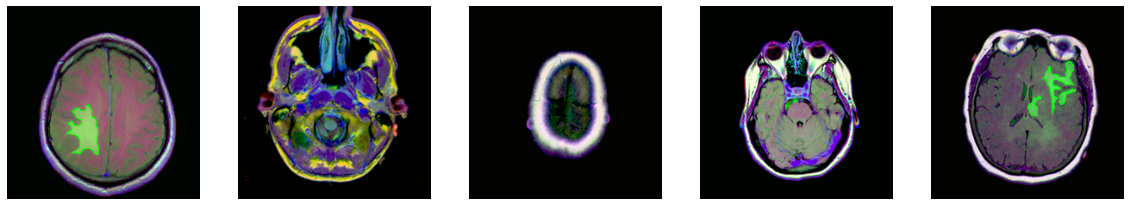

In [6]:
rand_idx = np.random.choice(len(labeled_dataset), 5)
samples = [toimage(labeled_dataset[idx]) for idx in rand_idx]
plot_samples(samples)

### Training

In [7]:
model = UNet(in_channels=3, out_channels=1)
model.to(params.device)
optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
loss_fn = DiceLoss()
metrics = {'dice score': dice_score}

In [8]:
train_eval(algorithm, model, optimizer, loss_fn, labeled_loader, unlabeled_loader, val_loader, metrics, params)

Epoch 1/30
100%|██████████| 190/190 [00:43<00:00,  4.40it/s, loss=0.896]
- Train metrics: dice score: 0.164 ; labeled loss: 0.961 ; unlabeled loss: 0.000 ; loss: 0.961
- Eval metrics : dice score: 0.512 ; labeled loss: 0.914
Epoch 2/30
100%|██████████| 190/190 [00:41<00:00,  4.63it/s, loss=0.861]
- Train metrics: dice score: 0.801 ; labeled loss: 0.787 ; unlabeled loss: 0.000 ; loss: 0.787
- Eval metrics : dice score: 0.563 ; labeled loss: 0.892
Epoch 3/30
100%|██████████| 190/190 [00:41<00:00,  4.61it/s, loss=0.824]
- Train metrics: dice score: 0.799 ; labeled loss: 0.780 ; unlabeled loss: 0.000 ; loss: 0.780
- Eval metrics : dice score: 0.767 ; labeled loss: 0.856
Epoch 4/30
100%|██████████| 190/190 [00:41<00:00,  4.59it/s, loss=0.769]
- Train metrics: dice score: 0.799 ; labeled loss: 0.722 ; unlabeled loss: 0.000 ; loss: 0.722
- Eval metrics : dice score: 0.641 ; labeled loss: 0.813
Epoch 5/30
100%|██████████| 190/190 [00:41<00:00,  4.58it/s, loss=0.692]
- Train metrics: dice score

### Evaluation

In [9]:
output_list = generate_outputs(model, val_loader, params, save=True)

/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:42: UserWarning: /pasteur/u/mottaghi/brain-segmentation/supervised_notebook_10_noaugmentation/outputs/val_49.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:42: UserWarning: /pasteur/u/mottaghi/brain-segmentation/supervised_notebook_10_noaugmentation/outputs/val_93.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:42: UserWarning: /pasteur/u/mottaghi/brain-segmentation/supervised_notebook_10_noaugmentation/outputs/val_102.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:42: UserWarning: /pasteur/u/mottaghi/brain-segmentation/supervised_notebook_10_noaugmentation/outputs/val_226.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:42: UserWarning: /pasteur/u/mottaghi/brain-segmentation/supervised_noteb

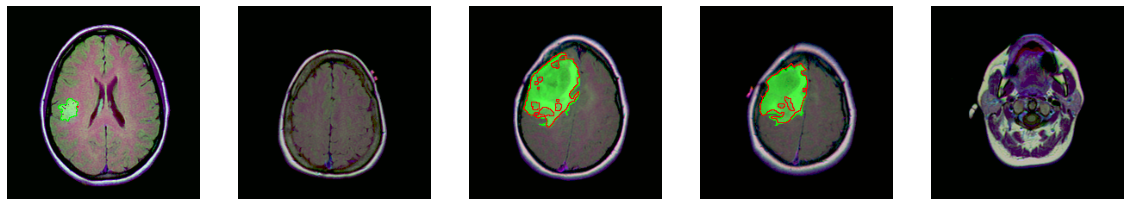

In [15]:
rand_idx = np.random.choice(len(output_list), 5)
samples = [output_list[idx] for idx in rand_idx]
plot_samples(samples)

In [11]:
# logs_dir = os.path.join(params.model_dir, "logs")
# %tensorboard --logdir {logs_dir} --host 0.0.0.0 --port 8818

In [12]:
# synthesize_results("/pasteur/u/mottaghi/brain-segmentation/experiments")